In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from threading import Thread
import time

# Portfolio Project

**Team Number:** 08 

**Team Member Names:** Deniz Makul, Richard Sha, Mitchel Shen

**Team Strategy Chosen:** Safe


# The Assignment: 

The goal of this assignment is to create a dynamic portfolio that generates the least amount of returns possible. We will analyze expected returns, standard deviation, and correlation, and use the results of our analysis to dynamically build a portfolio that we believe will stay as close as possible to the intial investment price of $500k.

In [2]:
#Getting tickers from csv file
csv_tickers = pd.read_csv('Tickers.csv', header = None)

# The Filtering Process:

The filtering process below will filter out stocks that are not to be utilized according to the assignment instructions. 

The following processes are performed

1. Trading months that have less than 20 trading days are filtered out and are not used for the process in Step 2

2. Stocks that have an average monthly volume of less than 200,000 shares are filtered out for the time interval January 01, 2022 - October 31, 2022 (months that have less than 20 trading days not looked at as mentioned in Step 1)

3. Non US-based stocks are filtered out

4. Delisted stocks are filitered out


After our filtering process, which makes use of threading for faster runtime, we receive a list of the indexes of our ineligible tickers, which we then use to create a dataframe of eligible tickers. 

In [3]:
# Returns a list of of months that have less than 20 trading days

#Setting start date and end date for volume filtering, we use Nov 1 as end date to access Oct 31 since end date is not inclusive
volume_start_date = '2022-01-01'
volume_end_date = '2022-11-01'

# This function returns a list of months with less than 20 trading days
def remove_month(ticker):
    
    #Grabs the daily data of stock
    hist = ticker.history(start = volume_start_date, end = volume_end_date)
    
    months_to_remove = []
    
    #Loops through each of the 10 months checking how many days are in each month
    for i in range(1,11,1):
        
        #If the month is a single digit month, we append a 0 in front of the month number
        if i <= 9: 
            i = str(0) + str(i)
            
        #Filters dataframe so that only data from month 'i' remains
        df = hist.filter(like='2022-' + str(i), axis=0)
        
        #Adds to month_to_remove array if there are less than 20 rows (signalling that there were less than 20 trading days for that stock)
        if len(df.index) < 20:
            months_to_remove.append('2022-' + str(i))
            
    return months_to_remove

In [4]:
#List to store which stocks to remove (based on indexes)
volume_index_drop = []

#Filter function, uses threading to speed up the process
def filter_stocks(ticker, i):
    
    #Grabs the monthly data of stock
    stock_data = yf.Ticker(ticker)
    stock_hist = stock_data.history(start = volume_start_date, end = volume_end_date, interval = '1mo', Threads = True)
    
    #If no data exists for a particular data, then the stock has been delisted, so we remove that stock
    if stock_hist.empty:
        volume_index_drop.append(i)
        return
    
    stock_volume = stock_hist['Volume']
    stock_volume = stock_volume.dropna()
    #Drops the month where there are less than 20 trading days
    stock_volume = stock_volume.drop(remove_month(stock_data))
    
    mean = (stock_volume.mean())
    
    #If the average monthly volume was less than 200000, or if the stock is not in the US market, 
    # the index of that stock is added to volume_index_drop
    if mean<200000:
        volume_index_drop.append(i)         
    elif(stock_data.info['market'] != 'us_market'):
        volume_index_drop.append(i)
    

In [5]:
# The threading process for faster runtime

# thread_list contains all the threads
thread_list = []

for i in range(len(csv_tickers)):
    ticker = csv_tickers[0][i]
    filter_thread = Thread(target = filter_stocks, args = (ticker,i,))
    thread_list.append(filter_thread)
    #starts the threading
    filter_thread.start()

for i in thread_list:
    i.join()
    
volume_index_drop

- AGN: No data found, symbol may be delisted
- CELG: No data found, symbol may be delisted
- RTN: No data found, symbol may be delisted
- PCLN: No data found for this date range, symbol may be delisted
- TWX: No data found for this date range, symbol may be delisted


[4, 16, 47, 40, 56, 48, 54]

Above, we produce a list of the indexes of stocks that need to be dropped. Which are then dropped below so that we end up with a dataframe of only valid tickers.

In [6]:
#Drops invalid tickers based on volume_index_drop
csv_tickers.drop(index = volume_index_drop, inplace = True)
csv_tickers.reset_index(drop = True, inplace = True)
csv_tickers.head()

,0
0,AAPL
1,ABBV
2,ABT
3,ACN
4,AIG


# The Time Period

Considering the extremely short-term nature of the competition (the value of the portfolio is being run and tracked for one week), we looked at the daily data from the start of the year until now. We do not look at data from years prior because there were massive fluctuations in stock prices due to the covid pandemic, and also because the trends that occured a couple of years ago likely would not help us build a short-term portfolio today.

Though there have been major market cataylsts that have moved markets this year (such as the Russia-Ukraine war that started in 2022), we felt that the time period starting from the beginning of the year provides with enough data for the stocks to determine the short term trends for the stocks to put into our portfolio but not so much data that it includes unncessary information that may act more of a hinderance than a help in analyzing the data.

In [7]:
close_all = pd.DataFrame()
#Gets the current date
close_date = datetime.today().strftime('%Y-%m-%d')

#Gets the close daily close price for all valid stocks in the csv file from January to the current date
def stock_history(ticker):
    close_start = '2022-01-01'
    stock_data = yf.Ticker(ticker)
    stock_hist = stock_data.history(start = close_start, end = close_date, interval = '1d')
    stock_close = stock_hist['Close']
    stock_close = stock_close.dropna()
    close_all[ticker] = stock_close

In [8]:
# Produces a dataframe with the closing prices 
for i in range(0,len(csv_tickers)):
    ticker = csv_tickers[0][i]
    stock_history(ticker)
    
close_all.head()

,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,SLB,SO,SPG,T,TGT,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,182.009995,134.029205,138.551285,406.156982,57.389999,170.404495,167.788895,207.860001,45.955307,244.139999,...,31.621540,67.475571,160.300003,18.700493,230.949112,190.600006,502.279999,246.562317,211.959869,57.270000
2022-01-04,179.699997,133.771881,135.292801,403.254517,59.000000,167.522003,173.175369,213.630005,47.756504,241.729996,...,33.156757,67.475571,162.979996,18.854919,233.159531,190.800003,490.899994,250.801544,215.722519,58.770000
2022-01-05,174.919998,134.474579,134.684937,396.152924,58.189999,164.356995,171.329987,213.070007,46.950443,239.270004,...,33.156757,67.554756,161.029999,19.274082,227.872452,186.820007,489.690002,251.557831,213.012222,58.459999
2022-01-06,172.000000,133.841156,134.665009,377.022522,59.189999,163.253998,172.899994,211.339996,47.895821,237.300003,...,33.944305,67.475571,163.160004,19.200544,230.351715,186.759995,469.649994,252.254440,215.077225,60.049999
2022-01-07,172.169998,133.494751,135.083527,369.791290,60.740002,162.554001,174.380005,215.500000,48.940712,232.600006,...,34.921265,67.940781,161.270004,19.856495,229.784164,179.440002,458.600006,253.538147,216.586258,61.000000


In [9]:
#Produces the daily percentage change of each stock
close_all_pct = close_all.pct_change() * 100
close_all_pct.head()

,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,SLB,SO,SPG,T,TGT,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,-1.269160,-0.191991,-2.351825,-0.714617,2.805368,-1.691559,3.210269,2.775909,3.919454,-0.987140,...,4.854973,0.000000,1.671861,0.825789,0.957102,0.104930,-2.265670,1.719333,1.775171,2.619172
2022-01-05,-2.659988,0.525296,-0.449295,-1.761070,-1.372884,-1.889309,-1.065615,-0.262134,-1.687856,-1.017661,...,0.000000,0.117354,-1.196464,2.223095,-2.267580,-2.085952,-0.246484,0.301548,-1.256381,-0.527482
2022-01-06,-1.669334,-0.471035,-0.014796,-4.829045,1.718508,-0.671098,0.916365,-0.811945,2.013564,-0.823338,...,2.375226,-0.117217,1.322738,-0.381537,1.088005,-0.032123,-4.092387,0.276918,0.969429,2.719809
2022-01-07,0.098836,-0.258818,0.310785,-1.917984,2.618691,-0.428778,0.855993,1.968394,2.181592,-1.980614,...,2.878124,0.689449,-1.158372,3.416312,-0.246384,-3.919465,-2.352813,0.508894,0.701624,1.582016


# Expected Return

In finance, expected return is the amount of profit or loss an investor can anticipate receiving over the life of the investment. It is calculated by multiplying potential outcomes by the odds that they occur and totaling the result. The formula for this is:

\begin{align*}
E(X)=\overline{X}=\frac{\sum x_i}{N}
\end{align*}

where $x_i$ are individual returns of some security $X$, $N$ is the total number of observations (time periods for us)

Expected return is a great tool for determining where to invest our $500k. It uses historical data to calculate the return (either profit or loss) that we expect on an investment. Even though expected return uses historical data, there's obviously no guarantee of future outcomes which is why expected return is only one of three factors used throughout our analysis. 

For this assignment, we'd like to have the lowest return on investment possible. That is, we want to choose the stocks that provide us the least profit/loss possible. Therefore, the stocks with an expected return closest to <b>0</b> can expect to receive a higher weighting in our dynamic portfolio. 

In [10]:
#Gets the expected return as a percentage for each stock over the period from January 1st, 2022 to most recent trading day
expected_return = close_all_pct.mean()
expected_return.head()

AAPL   -0.057359
ABBV    0.087845
ABT    -0.104313
ACN    -0.121394
AIG     0.049530
dtype: float64

In the step below, we take the absolute value of our expected returns. This is because we want the stocks with the minimum stock movements, regardless of whether it is positive or negative. Now that all values are positive, our expected returns are then sorted in increasing order so that the stocks at the top of the list have expected returns closest to 0. Only the first 5 elements of the list are displayed for spacing reasons. 

In [11]:
#Gets the absolute differnce of the expected return from 0
expected_return_from_0 = abs(0 - expected_return)
expected_return_from_0

#Sorts the values in expected_return_from_0 from least to greatest
expected_return_sorted = sorted(expected_return_from_0.items(), key=lambda x:x[1])

#Displays first 5 elements only, actual list is longer
expected_return_sorted[:5]

[('CVS', 0.000489297221195544),
 ('SO', 0.0030077792627017726),
 ('COST', 0.005784077173002263),
 ('TXN', 0.007047229837583318),
 ('ORCL', 0.0070476010095530724)]

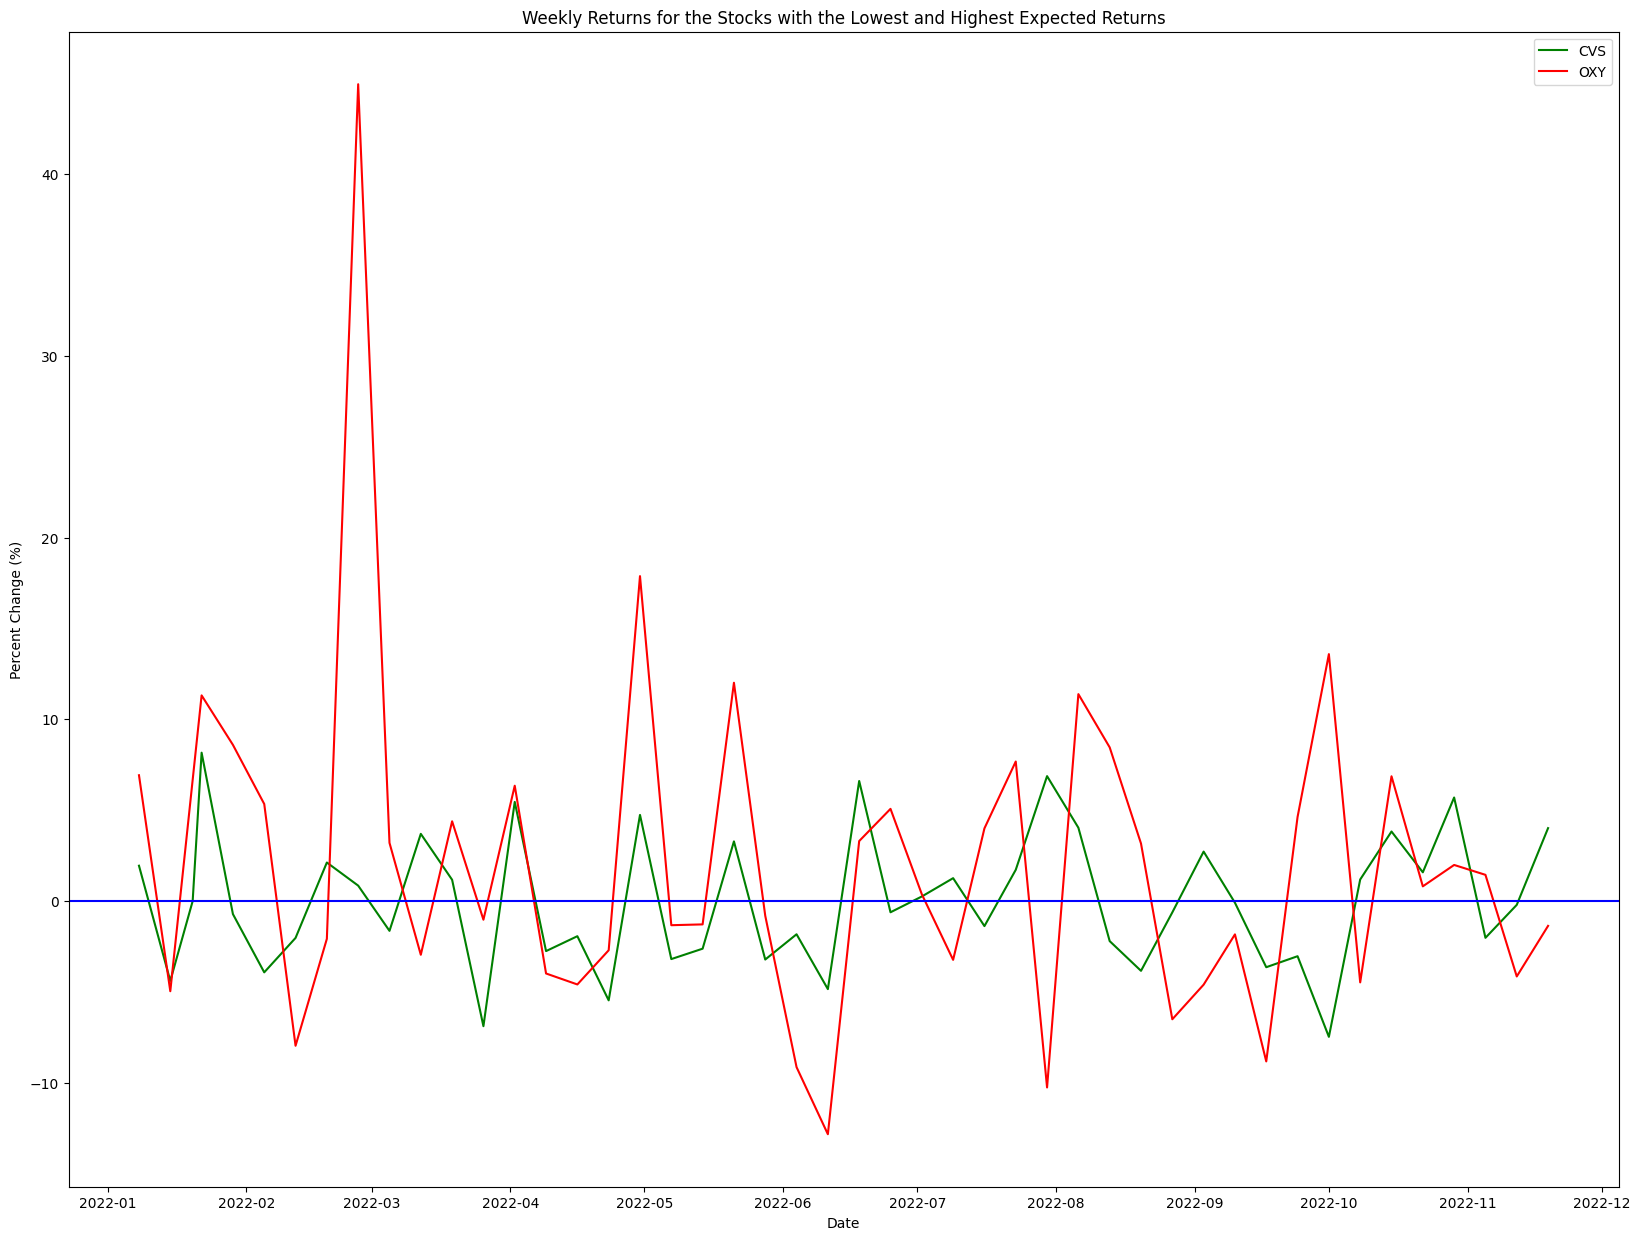

In [12]:
start_date = '2022-01-01'

lowest_expected = expected_return_sorted[0][0]
highest_expected = expected_return_sorted[-1][0]

lowest = yf.Ticker(lowest_expected)
lowest_hist = lowest.history(start=start_date, end=close_date, interval="1wk")
lowest_df = pd.DataFrame(lowest_hist.Close)
lowest_df_pct = lowest_df.pct_change()*100

highest = yf.Ticker(highest_expected)
highest_hist = highest.history(start=start_date, end=close_date, interval="1wk")
highest_df = pd.DataFrame(highest_hist.Close)
highest_df_pct = highest_df.pct_change()*100

plt.figure(figsize=(20,15))

plt.plot(lowest_df_pct.index, lowest_df_pct['Close'], color = 'g', label=lowest_expected)
plt.plot(highest_df_pct.index, highest_df_pct['Close'], color = 'r', label=highest_expected)
plt.axhline(y=0, color='b', linestyle='-')

plt.legend(loc='best')

plt.title('Weekly Returns for the Stocks with the Lowest and Highest Expected Returns')
plt.xlabel('Date')
plt.ylabel('Percent Change (%)')

plt.show()

Looking at the graph above, the stock with the largest absolute value expected return from Januaray 2022 to today is noted with the red line, while the stock with the lowest absolute value expected return from January to today is noted with the green line. Note that we decided to graph the weekly percentage change rather than the daily percentage change because the data is much easier to track and visualize on a weekly basis rather than on a daily basis. From visually looking at the graph, it is obvious that the stock with the largest absolute value expected return has higher fluctuations in stock prices compared to the stock with the lowest absolute value expected return, although not by a substantial amount. However, looking at these two lines, we would much rather put the stock with the lowest absolute value expected return, since there is less fluctuations to the return of the stock.

However, notice that we cannot rely solely on this metric to judge whether to put a stock in our portfolio or not, since having a low absolute value expected return can still mean there are high fluctuations in stock price; it just has to be that the average of those fluctuations add up to a low value, typically near 0. This observation can also be seen in the graph, as even though the stock with the highest average absolute value expected return may be much more than the lowest average absolute value expected return, the graphs to not differ in their fluctuations by a substantial amount. Thus, we have to consider other metrics to judge whether a stock fits our portfolio and our objectives for the portfolio.

# Standard Deviation

One of the most important tools that analysts have in evaluating the risk of a stock is the standard deviation. In the stock market, the standard deviation represents the variance a particular stock's percentage change from the mean, in this case the average percentage change. A stock with a high standard deviation, therefore, would have large daily percentage changes in values, which would cause the price to fluctuate rapidly in a short amount of time. Since we want to generate the safest portfolio, we want the stocks that have the least day to day flucations in stock price, regardless of whether the stock goes up or down. Therefore, using standard deviation offers a great metric by which we could judge the riskiness of a particular stock. For out portfolio, we would want to select stocks with the lowest standard deviation values. 

In the code block above, we calculated the standard deviation for each ticker and appended into a list called ‘std_lst’. After that, we sorted the list so that the ticker by ascending order so that the lowest standard deviation would be at index 0, the start of the list. The reason we sorted the standard deviation by ascending order was so that the stock at the first index would be the ticker with the lowest standard deviation. Later on, we will be taking this list and assigning each ticker points based on the index at which the ticker appears in the list.

In [13]:
#Gets the standard deviation of each stock from January 1st to October 31st, 2022
std_lst = close_all_pct.std()
std_lst = sorted(std_lst.items(), key=lambda x:x[1])

#Displays first 5 elements of list, actual list is longer
std_lst[:5]

[('MON', 0.14264741494307842),
 ('PEP', 1.269035863389035),
 ('BMY', 1.2702216106524624),
 ('KO', 1.2833324318855914),
 ('MRK', 1.2931005256909804)]

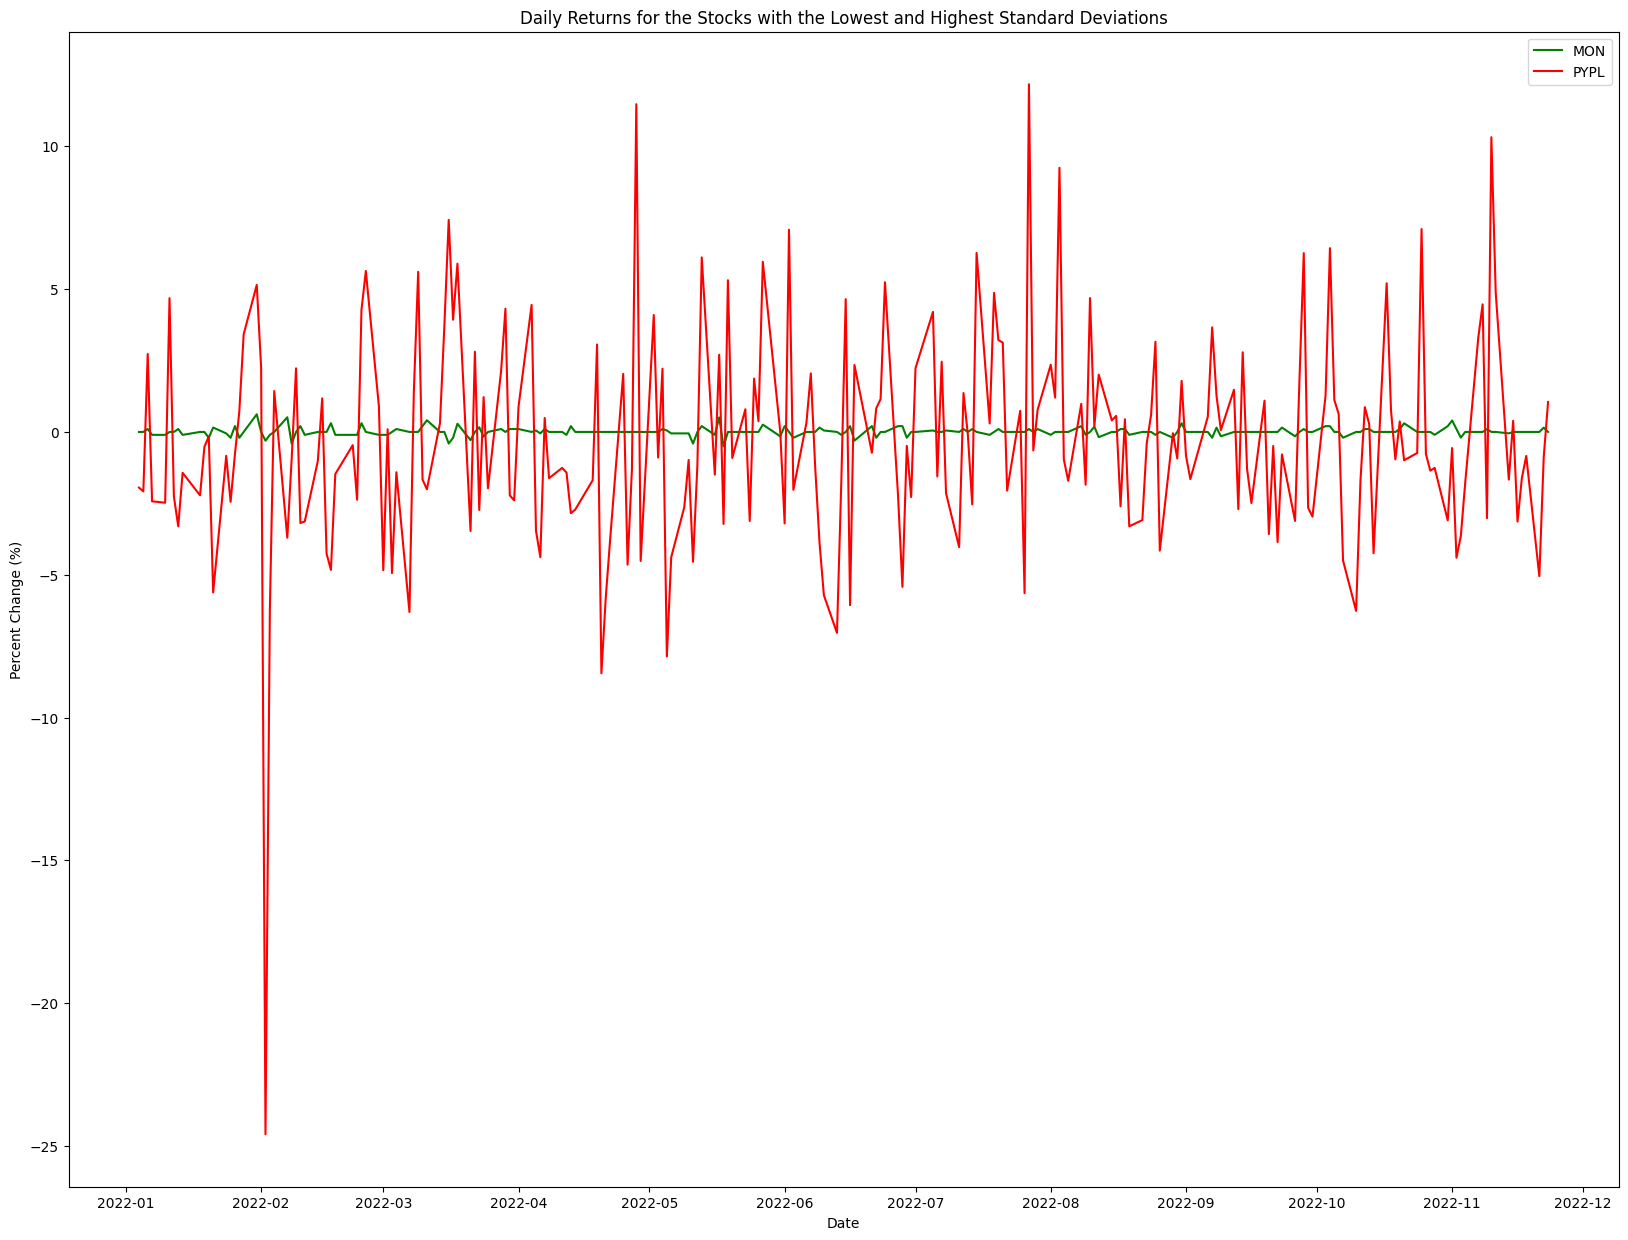

In [14]:
lowest_std = std_lst[0][0]
highest_std = std_lst[-1][0]

plt.figure(figsize=(20,15))

plt.plot(close_all_pct.index, close_all_pct[lowest_std], color = 'g', label=lowest_std)
plt.plot(close_all_pct.index, close_all_pct[highest_std], color = 'r', label=highest_std)

plt.legend(loc='best')

plt.title('Daily Returns for the Stocks with the Lowest and Highest Standard Deviations')
plt.xlabel('Date')
plt.ylabel('Percent Change (%)')

plt.show()

As you can see from the graph above, the ticker with the highest standard deviation out of the valid ticker list, which is the represented by the red line, fluctuates significantly more than the ticker that has a the lowest standard deviation, represented by the green line. This is because in portfolios, standard deviation is a measure of risk and so a stock with a higher standard deviation will be more risky than a stock with a lower standard deviation. If we added the stock with the greater deviation, the value of our portfolio would flucuate a lot more than if we added the stock with the lower stnadard deviation. By assigning more points and thus weighting the stock with the lower standard deviation higher, we are ensuring that our portfolio will be as safe as possible by mitigating and reducing the number of significant fluctuations that occur in a given trading day.

In [15]:
correlation_pct_stocks = pd.DataFrame()
index = []

#Creates a DataFrame that stores correlation between any two given stocks given that the ticker is acceptable
for i in range(len(close_all_pct.columns)):
    
    #Tracks the correlation of one stock to every stock in the portfolio
    correlation_temp = {}
    
    for j in range(len(close_all_pct.columns)):
        #correlation_df: Temporary dataframe so that .corr() function can be applied to the dataframe
        correlation_df = pd.DataFrame({
            csv_tickers[0][i]: close_all_pct[csv_tickers[0][i]]
        })
        
        correlation_df[csv_tickers[0][j]] = close_all_pct[csv_tickers[0][j]]
        correlation = correlation_df.corr()[csv_tickers[0][i]][csv_tickers[0][j]]
        
        correlation_temp[csv_tickers[0][j]] = correlation
        
    correlation_pct_stocks[csv_tickers[0][i]] = list(correlation_temp.values())
    index.append(csv_tickers[0][i])

#Sets resets index values for better understanding of data
correlation_pct_stocks.index = index
correlation_pct_stocks.head()

,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,SLB,SO,SPG,T,TGT,TXN,UNH,UNP,UPS,USB
AAPL,1.000000,0.212476,0.617065,0.797808,0.553380,0.690033,0.653220,0.537519,0.567874,0.297580,...,0.205614,0.388616,0.592486,0.390810,0.521387,0.724884,0.482072,0.479803,0.554151,0.486013
ABBV,0.212476,1.000000,0.452144,0.326837,0.309524,0.204599,0.273148,0.108353,0.293036,0.229278,...,0.173926,0.364250,0.265727,0.280066,0.264366,0.254740,0.489960,0.247771,0.228892,0.382459
ABT,0.617065,0.452144,1.000000,0.697916,0.535801,0.505125,0.596883,0.428366,0.576459,0.323183,...,0.115791,0.451650,0.529855,0.376927,0.405675,0.541372,0.558056,0.494422,0.484853,0.560514
ACN,0.797808,0.326837,0.697916,1.000000,0.589215,0.693313,0.667075,0.506539,0.590891,0.373930,...,0.197476,0.415423,0.629489,0.376733,0.525057,0.736906,0.519115,0.551450,0.587065,0.540402
AIG,0.553380,0.309524,0.535801,0.589215,1.000000,0.456342,0.729389,0.537039,0.757203,0.246250,...,0.393880,0.293886,0.599023,0.376116,0.336363,0.490358,0.384214,0.500508,0.517223,0.726190


# Correlation

For correlation, we calculated the correlation of a stock to each stock and put it in a dataframe to be analyzed. In Finance, correlation is a metric used to determine how the stock movements of two stocks, or portfolios of stocks, compare. The formula for correlation is given by: 

\begin{align*}
COR(X,Y)=\frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
\end{align*}

where the covariance of X and Y is divided by the standard deviation of X is multipled by the standard deviation of Y

A correlation of 1 means that the two stocks being compared move perfectly together, both up and down. A correlation of -1 means that the two stocks being analyzed move in opposite directions all the time in perfect fashion. In the real world, both cases of correlation of 1 and -1 for two particular stocks is highly unlikely to happen, as even the smallest deviation would cause the correlation to not be 1 or -1. Finally, a correlation of 0 suggests that there is no pattern or correlation between the two stocks at all. Like the case of a correlation of 1 and -1, a correlation of 0 between two stocks is highly unlikely as even two stocks with the most random stock movements will always have some relationship, albeit small in magnitude.


In [16]:
#Tracks the average correlation of a stock to the rest of the stocks
correlation_pct_mean = pd.DataFrame()
correlation_pct_mean = correlation_pct_stocks.sum()

#Subtracts 1 to account for the case in the dataframes where a stock is compared to itself for correlation
#the correlation would be 1 in this case (such as AAPL's correlation with AAPL)
correlation_pct_mean = correlation_pct_mean - 1

#One less stock (len(correlation_pct_stocks) - 1)since we don't take into account the stock itself in the 
#correlation calculations
correlation_pct_mean = correlation_pct_mean/(len(correlation_pct_stocks) - 1)

correlation_pct_mean.head()

AAPL    0.498219
ABBV    0.292076
ABT     0.472507
ACN     0.520740
AIG     0.470715
dtype: float64

For our portfolio, we want the safest portfolio, where there is minimal movement to the value of the portfolio at all times. From our diversification discussion, we wanted to pick as many stocks as possible to put in our portfolio, which complicates things since correlation is typically a measure of the relationship between only two stocks. Thus, we decided to take the average correlation of a stock to the stocks in the rest of the ticker list. Since we are going for the safest portfolio, one may assume that stocks that have high negative average correlation values will pair well with stocks that have high positive average correlation values to attain as little movement between the stocks as possible. From this strategy, we would pick pairs of stocks with high and low correlations to be put in the portfolio together. However, there may be an uneven distribution of stocks that have high positive average correlation values and high negative average correlation values. In the case of the example tickers given to test the code, there were NO stocks that had an average correlation value below 0. In addition, it may be hard to find a perfect pair of stocks with high negative average correlation and high positive average correlation values. Due to these uncertainties, we need another more robust method of considering stocks based on the correlation with the rest of the tickers.

From the portfolio theory that we learned in class, stocks that have little correlation with each other (near 0) mitigates risk and increases the safety of stock since when a stock goes down, the other stock may not have decreased, and thus will help mitigate some of the losses attained by the first stock that decreased in value. On the contrary, if the value of a stock went up, another stock that had a correlation near 0 might not have, and thus will reduce the profits attained by both stocks, hence creating a portfolio that has minimal movement in value. Thus, we settled on weigthing/favouring stocks that had average correlation values near zero.

Hence, the code block below sorts the average correlation values for each stock from the stocks with least difference between average correlation values and 0 to the stocks with the stocks with the highest difference between average correlation values and 0.


In [17]:
#Gets the absolute value of the correlation from 0 (least correlation) and sorts it from least to greatest
correlation_from_0 = abs(0 - correlation_pct_mean)
correlation_from_0 = sorted(correlation_from_0.items(), key=lambda x:x[1])

# The Point-Weighting System

The following sections applies our above analyses into creating a dynamic portfolio.

### The Importance of Diversification
    
Our program aims to make use 25 stocks if possible, since that is the maximum allowed number of stocks in our portfolio. The more stocks there are, the greater the chance of inter-industry variation in our portfolio, since there is a greater chance that a stock from a different industry will be added to our portfolio. This brings up the importance of diversification. By allocating investments across various stocks and industries, we are able to minimize risk so that if something happens to one stock, the change incurred by this stock will be counterbalanced by the other stocks in our portfolio. This will help reduce the volatility experienced by the portfolio over the week-long simulation to help acheive minimal returns on investments, as desired by the assignment.

### The Point System

We developed a point-weighting system to determine how much of each stock we would like to purchase for the simulation. We begin by applying our point system which will award the most points to our safest stock. The results from our analyses of expected return, standard deviation, and correlation are used to create a dataframe. This dataframe contains those 3 categories sorted in increasing order, accompanied by an index in decreasing order ranging from the total number of stocks to 1.

<b>The index represents the number of points that will be awarded to each stock for each category. 

Say, for example, in a field of 30 stocks, AT&T (NYSE: T) places 1st in expected returns, 3rd in standard deviation, and 29th in correlation. Our index would range from 30 in the first row down to 1 for the bottom row. Our point-based system would then award 30 points for expected returns, 28 points for standard deviation, and 2 points for correlation, for a total of 60 points. This means that each category is essentially weighted equally at ⅓.

The result of this application can be seen on the following dataframe, where the total points for each stock has been tallied up. The stock at the top of the list is seen as our "safest" stock and will receive the most weighting, while the stock at the bottom is seen as our riskiest, and probably won't even be included in our portfolio entirely. 
    
The resulting dataframe is then given a cutoff so that only the top 25 stocks remain in our dataframe, the maximum allowed for this assignment. In the rare case that we happen to receive a stock list with fewer than 25 stocks, than all will be included in our portfolio for the sake of diversification. 
 
    



In [18]:
#Creates points system
points_system = pd.DataFrame()
expected_lst = []
std_deviation_lst = []
correlation_lst = []

#Appends each stock and their rankings in the expected_lst, std_deviation and correlation_lst dataframes
for i in expected_return_sorted:
    expected_lst.append(i[0])
    
for i in std_lst:
    std_deviation_lst.append(i[0])

for i in correlation_from_0:
    correlation_lst.append(i[0])

points_system['Expected Returns'] = expected_lst
points_system['Standard Deviation'] = std_deviation_lst
points_system['Correlation'] = correlation_lst
points_system.index += 1 

#Inverses the index for the points system
points_system = points_system.set_index([points_system.index[::-1]])

points_system.head()

,Expected Returns,Standard Deviation,Correlation
55,CVS,MON,MON
54,SO,PEP,LMT
53,COST,BMY,OXY
52,TXN,KO,SLB
51,ORCL,MRK,COP


In [19]:
#Score dataframe keeps track of the points accumulated by a stock in all three categories (expected returns, standard deviation,
#correlation)
score = pd.DataFrame()
    
score['Tickers'] = expected_lst
score['Points'] = None

for i in range(len(score)):
    score['Points'][i] = (int(points_system[points_system['Expected Returns'] == expected_lst[i]].index.values)) + (int(points_system[points_system['Standard Deviation'] == expected_lst[i]].index.values)) + (int(points_system[points_system['Correlation'] == expected_lst[i]].index.values)) 

#Recreates index so that it is from 1 to (# of stocks)
score = score.sort_values("Points")
score = score[::-1]
score = score.reset_index(drop=True)
score.index += 1 

score.head()

,Tickers,Points
1,MON,158
2,SO,144
3,MO,140
4,PM,134
5,CL,132


In [20]:
#Creates a dataframe of the top stocks to pick (25 stocks if there are 25 or more stocks in the list, the same dataframe as 
#score if there are less)

number_of_stocks = 25

score_dropped = score.copy()

#Accounts for the case where there are less than the number of stocks we want (25) valid tickers in the list; only when 
#there are more than 25 valid tickers would we take the first 25 tickers from the score dataframe
if (len(score) > number_of_stocks):
    score_dropped.drop(labels = range(number_of_stocks + 1, len(score) + 1), inplace = True)
score_dropped.head()

,Tickers,Points
1,MON,158
2,SO,144
3,MO,140
4,PM,134
5,CL,132


 
### The Weighting System
    
After the points have been calculated for each stock, we apply our weighting system. The weighting system awards a base weighting of [100/(2 x # of Stocks)] to each stock, since each stock must make up a minimum of 2% of the portfolio according to assignment instructions. The rest of the weighting is calculated by dividing the points belonging to the stock by the total number of points, and then multiplying the resulting value by (100 - base weight). Our weighting system makes it so that there isn't much variation between the top stock and the bottom stock of our portfolio. As you should be able to see, the top and bottom stock are no more than a couple percentage points off from each other, safely within allowed bounds for this assignment.

In [21]:
#Minimum weighting possible for any given stock so that there is no case where the weighting of one stock drops below the 
#minimum weighting requirement for a given stock
min_weighting = 100/(2*number_of_stocks)
base_weighting_total = min_weighting * number_of_stocks

#Gets the finalized weightings of each stock
score_dropped['Base Weighting'] = min_weighting
weighting_sum = score_dropped['Points'].sum()

score_dropped['Points-based Weighting'] = (score_dropped['Points']/weighting_sum) * (100 - base_weighting_total)
score_dropped['Total Weighting'] = score_dropped['Base Weighting'] + score_dropped['Points-based Weighting']
score_dropped.head()

,Tickers,Points,Base Weighting,Points-based Weighting,Total Weighting
1,MON,158,2.0,2.728843,4.728843
2,SO,144,2.0,2.487047,4.487047
3,MO,140,2.0,2.417962,4.417962
4,PM,134,2.0,2.314335,4.314335
5,CL,132,2.0,2.279793,4.279793


<b>The code below creates a dataframe of the close price on the most recent trading day

In [22]:
tickers_list = score_dropped['Tickers']
#Gets the closing price for last five days. Five days incase the program is run on the weekend and Friday is a holiday
price_last_five_days = pd.DataFrame()
Portfolio_Final = pd.DataFrame()
date_difference = 5

#initialize start_date for getting close dates from yfinance
start_date = datetime.today() - timedelta(days=date_difference)

#Getting price info for the last date (in this case 2022-11-25)
for x in tickers_list:
    stock_info = yf.Ticker(x)
    stock_hist = stock_info.history(start = start_date, end = close_date)
    
    price_last_five_days[x] = stock_hist['Close']
    
price_last_five_days = price_last_five_days.transpose()
#Gets the last column from price_last_five_days
Portfolio_Final = price_last_five_days.iloc[:,-1]
Portfolio_Final = Portfolio_Final.reset_index()
Portfolio_Final.index += 1

Portfolio_Final.head()

,index,2022-11-23 00:00:00
1,MON,10.010000
2,SO,66.360001
3,MO,45.020000
4,PM,98.110001
5,CL,76.930000


# Final Observations

For our portfolio, we have built a portfolio based on key metrics such as the expected return, standard deviation and correlation certain stocks. Note that from the final weightings, there is no stock that is more heavily weighted than other stocks. Thus, the portfolio is more evenly distributed, although not perfectly even distributed. As these results are based on past results, statistical anomalies may occur in the future, and as a result, any one of these stocks may have a sudden volatile movement regardless of past performance. Since the portfolio is pretty evenly distributed, the volatile movement of one individual stock will not greatly affect the performance of the portfolio. 

While the stock market is unpredictable, we firmly believe that our portfolio has the capacity to minimize changes in value to the portfolio. 

In [23]:
total_amount_to_spend = 500000
#To reset column names
column_names = ['Ticker', 'Price']
Portfolio_Final.columns = column_names

#Getting the rest of the columns for the Portfolio_Final dataframe
Portfolio_Final['Shares'] = (total_amount_to_spend*(score_dropped['Total Weighting']/100))/Portfolio_Final['Price']
Portfolio_Final['Value'] = Portfolio_Final['Shares'] * Portfolio_Final['Price']
Portfolio_Final['Weight'] = score_dropped['Total Weighting']
Portfolio_Final


,Ticker,Price,Shares,Value,Weight
1,MON,10.010000,2362.059303,23644.214162,4.728843
2,SO,66.360001,338.083679,22435.233161,4.487047
3,MO,45.020000,490.666588,22089.810017,4.417962
4,PM,98.110001,219.872339,21571.675302,4.314335
5,CL,76.930000,278.161493,21398.963731,4.279793
6,CVS,100.059998,210.409166,21053.540587,4.210708
7,PG,146.449997,142.579921,20880.829016,4.176166
8,T,19.090000,1089.286174,20794.47323,4.158895
9,ABBV,159.389999,127.212112,20276.338515,4.055268
10,NEE,84.919998,237.752981,20189.982729,4.037997


In [24]:
totalWeight = Portfolio_Final["Weight"].sum(axis=0)
print( "Total Weight of Portfolio: " + str(round(totalWeight, 2)) + "%")

Total Weight of Portfolio: 100.0%


In [25]:
totalValue = Portfolio_Final["Value"].sum(axis=0)
print( "Total Value of Portfolio: $" + str(round(totalValue,2)))

Total Value of Portfolio: $500000.0


In [26]:
#Generating Stocks_Final portfolio
Stocks_Final = pd.DataFrame()

Stocks_Final['Ticker'] = Portfolio_Final['Ticker'] 
Stocks_Final['Shares'] = Portfolio_Final['Shares']

Stocks_Final

,Ticker,Shares
1,MON,2362.059303
2,SO,338.083679
3,MO,490.666588
4,PM,219.872339
5,CL,278.161493
6,CVS,210.409166
7,PG,142.579921
8,T,1089.286174
9,ABBV,127.212112
10,NEE,237.752981


In [27]:
#Writing to csv file
Stocks_Final.to_csv("Stocks_Group_08.csv")

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Deniz Makul, Richard Sha, Mitchel Shen.